In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append('../..')
from hamp_pred.src.input_prep.prepare_sequence import MultiChainOperator, SeqWindow
from hamp_pred.src.input_prep.encode import MultiEncoder, OneHotEncoderSeq, RadianEncoder 
from hamp_pred.src.input_prep.encode import RadiousPhobosEncoder
from hamp_pred.src.predictor_config import PredictionConfig 
from hamp_pred.src.models.common.models import BaseConvolutionalWrapper 
from hamp_pred.src.predictor import Predictor
from collections import defaultdict

## Prepare data

In [2]:
DATA_DIR = '../../data/input'

# data set contains train and validation sets
# the val set is used for eraly stopping 
data = f'{DATA_DIR}/af_all_params_clean_model1.p'
data = pd.read_pickle(data)

data['train_seq'] = data.apply(lambda x: x['n_seq'] + x['c_seq'], axis=1)


assert all(data['train_seq'].str.len() == 22)

# separate test set used to pick the best model
#data_test = f'{DATA_DIR}/af_clean_model_test.p'
#data_test = pd.read_pickle(data_test)

In [23]:
def train(data, conf, version):
    operator = MultiChainOperator(MultiEncoder([RadiousPhobosEncoder(), OneHotEncoderSeq()]), SeqWindow(11, 11), RadianEncoder(100),  SeqWindow(11, 11, null_char=[[0]]),
                                          parallel=True)
    conf = PredictionConfig(BaseConvolutionalWrapper, operator, conf)
    mod = Predictor('hamp_all_params_per_helix', config=conf, version=version)
    trained = mod.train(data)
    return mod, trained

def get_mod(conf=None, version=None):
    operator = MultiChainOperator(MultiEncoder([RadiousPhobosEncoder(), OneHotEncoderSeq()]), SeqWindow(11, 11), RadianEncoder(100),  SeqWindow(11, 11, null_char=[[0]]),
                                          parallel=True)
    conf = PredictionConfig(BaseConvolutionalWrapper, operator, conf)
    mod = Predictor('hamp_all_params_per_helix', config=conf, version=version)
    return mod

def get_pdb_results(test_data, mod, predictions=None, use_diffs=False):
    predictions = predictions or ["n_crick_mut", "n_shift", "n_radius", "n_pitch", "n_P", "n_p",
                                  "c_crick_mut", "c_shift", "c_radius", "c_pitch", "c_P", "c_p"]
    if use_diffs:
        predictions = list({pred[2:] for pred in  predictions})
    true_results = defaultdict(list)
    predictions_results = defaultdict(list)
    
    seq = []
    tr = []
    for n,r in test_data.iterrows():
        seq.append(r['n_seq'] + r['c_seq'])
        for prediction in predictions:
            if use_diffs:
                result  = r["n_" + prediction] - r["c_" + prediction]
            else:
                result = r[prediction]
            res = np.mean((result[0::2] + result[1::2]) / 2)/2
            predictions_results[prediction].append(res)
            
    res = mod.predict(seq)
    pr = []
    for n,r in res.iterrows():
        for nc, prediction in enumerate(predictions):
            if use_diffs:
                result  = r["n_" + prediction] - r["c_" + prediction]
            else:
                result = r[prediction]
            res = np.mean(result)/2
            true_results[prediction].append(res)
    return predictions_results, true_results

def get_rmse(val, mod):
    params = ["n_crick_mut", "n_shift", "n_radius", "n_pitch", "n_P", "n_p",
                                  "c_crick_mut", "c_shift", "c_radius", "c_pitch", "c_P","c_p"]
    params_rmse = {param: 0 for param in params}
    tr_d = {param: 0 for param in params}
    pr_d = {param: 0 for param in params}
    seqs = list(val.train_seq)
    for key in params_rmse:
        tr=[]
        for n,r in val.iterrows():
            tr.append(np.mean((r[key][0::2] + r[key][1::2]) / 2)/2)
            tr_d[key] = tr
    res = mod.predict(seqs)
    size=1
    cnt=0
    step = len(params_rmse) + 1
    for key in params_rmse:
        pr = []
        for n,r in res.iterrows():
            pr.append(np.mean(r[key])/2)
            pr_d[key] = pr
        cnt+=1
    for key in params_rmse:
        params_rmse[key] = np.mean((np.array(tr_d[key])-np.array(pr_d[key])) **2 ) ** 0.5
    return params_rmse

def opt_conf(data, tune=False):
    
    # data: train and val (val for the eraly stopping)
    
    data_val = data[data['class'] == 'val']
    
    results = {}

    # parameters grid
    kernels = [(3, 4, 7)]
    layers = [3]
    lstm = [1, 2]
    dense = [1, 3]
    
    for kern in kernels:
        for l in layers:
            for ls in lstm:
                for d in dense:
                    model_config = {
                        'activation': 'tanh',
                        'norm': True,
                        'n_layers': l,
                        'kernel_sizes': kern,
                        'lstm': ls,
                        'dense': d,
                        'reshape_out': False,
                        'epochs': 100
                    }
                    version = '_'.join([str(x) for x in ["_".join([str(i) for i in kern]), l, ls, d]])
                    if tune:
                        mod, trained = train(data, model_config, version)
                    else:
                        mod = get_mod(model_config, version)
                        
                    results[version] = (get_rmse(data_val, mod), model_config)
                    print(results[version][0])
    return results

## Train Model

In [4]:
# results = opt_conf(data, True)

## Load Model

In [5]:
best_model_config = {'activation': 'tanh',
 'norm': True,
 'n_layers': 3,
 'kernel_sizes': (3, 4, 7),
 'lstm': 2,
 'dense': 1,
 'reshape_out': False,
 'epochs': 100,
 'task': 'hamp_rot',
 'version': "3_4_7_3_1_3"}

best_file = None
mod = get_mod(conf=best_model_config, version="3_4_7_3_1_3")

## Test on PDB

In [6]:
test_data = pd.read_pickle(f'{DATA_DIR}/pdb_measure_all.p')

In [7]:
test_data = test_data[~test_data.mutant]
test_data.rename(columns={'seq1':'n_seq', 'seq2':'c_seq', 'n_list':'n_crick_mut', 'c_list':'c_crick_mut'}, inplace=True)
test_data['n_seq'] = test_data['n_seq'].apply(lambda x: x[1:-1])
test_data['c_seq'] = test_data['c_seq'].apply(lambda x: x[1:-1])
test_data['train_seq'] = test_data.apply(lambda x: x['n_seq'] + x['c_seq'], axis=1)
len(test_data)

11

In [25]:
pr, tr = get_pdb_results(test_data, mod, use_diffs=True)

1/1 [==============================] - 1s 644ms/step


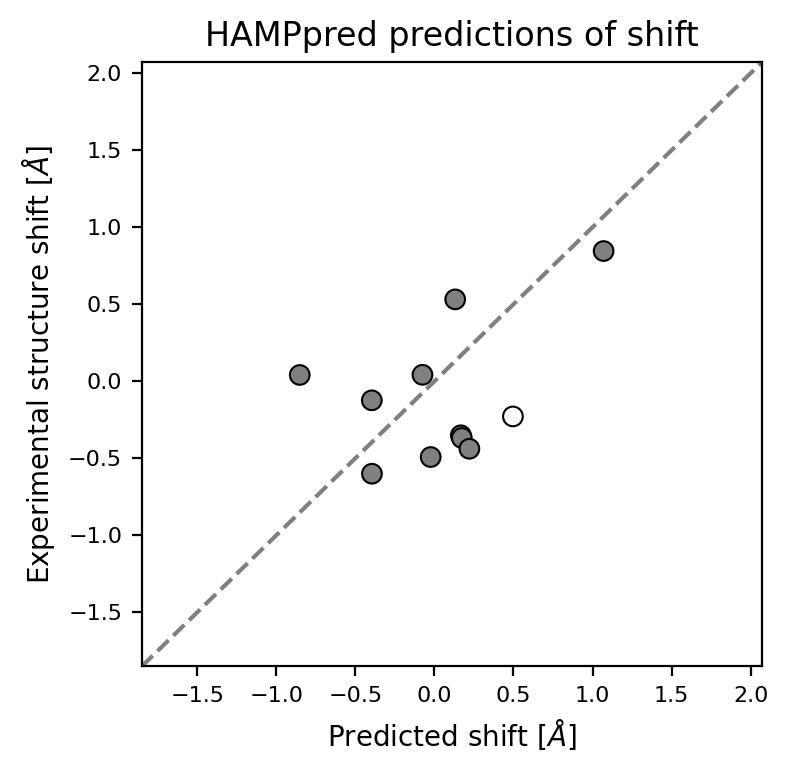

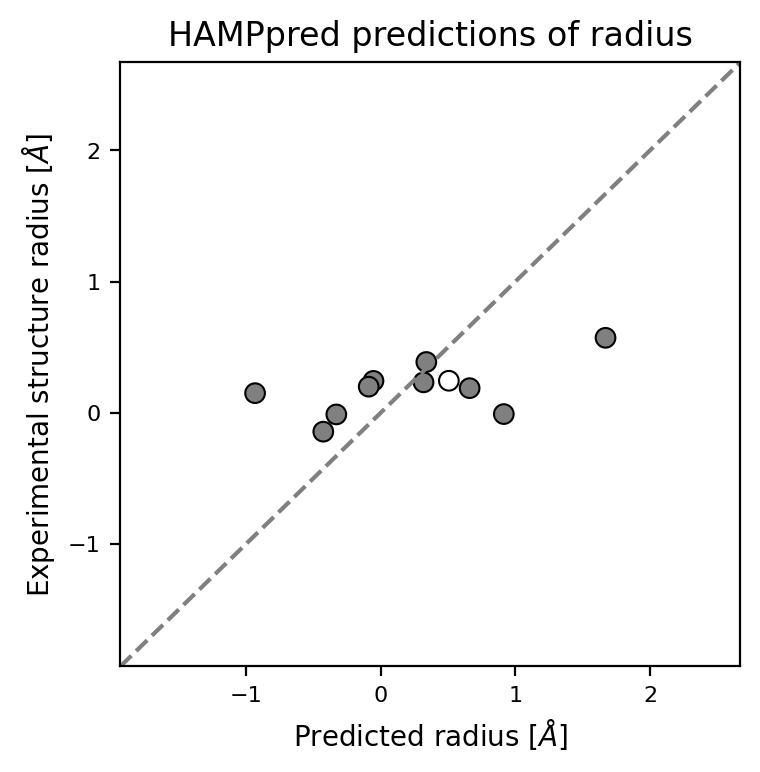

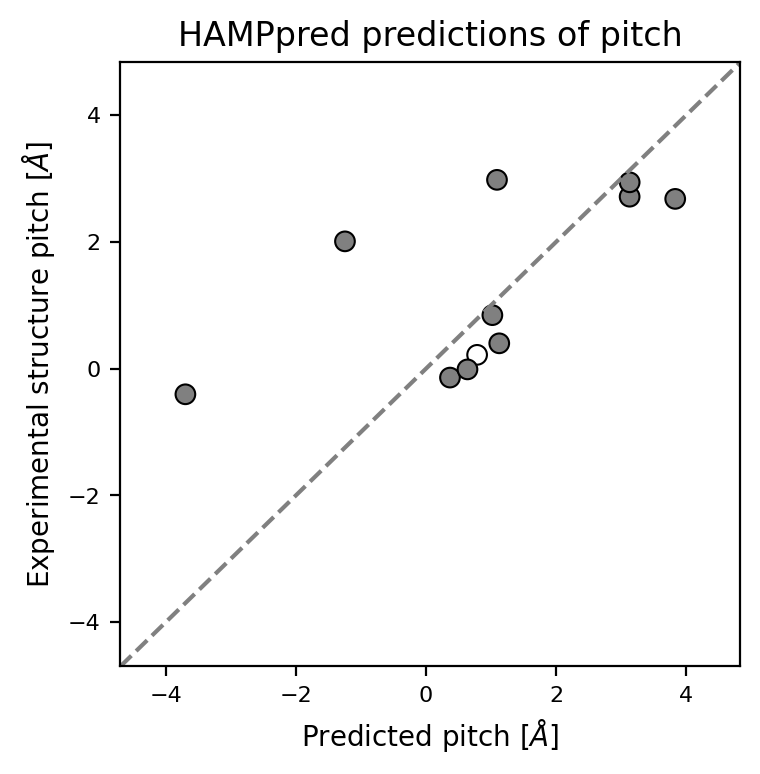

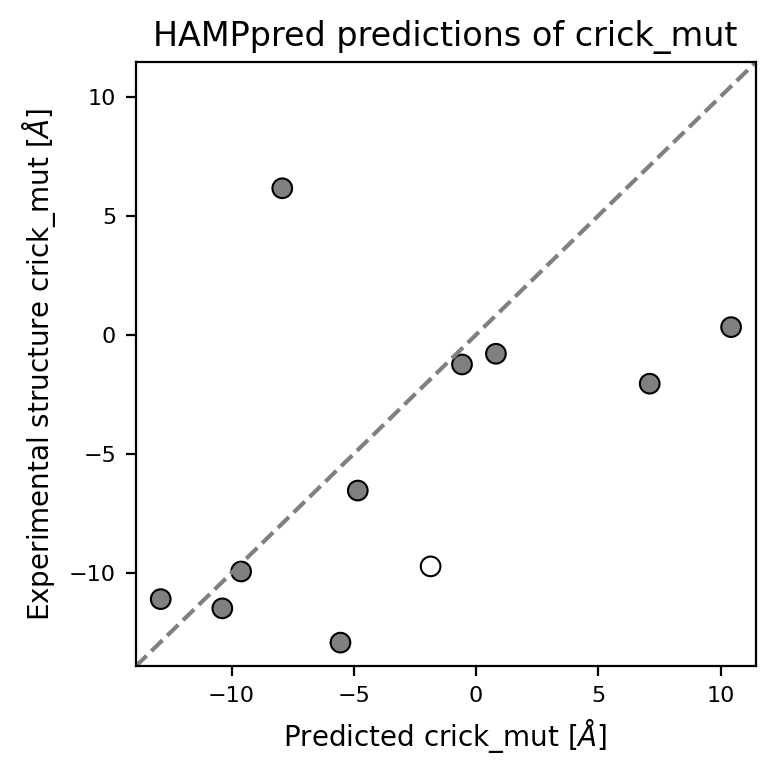

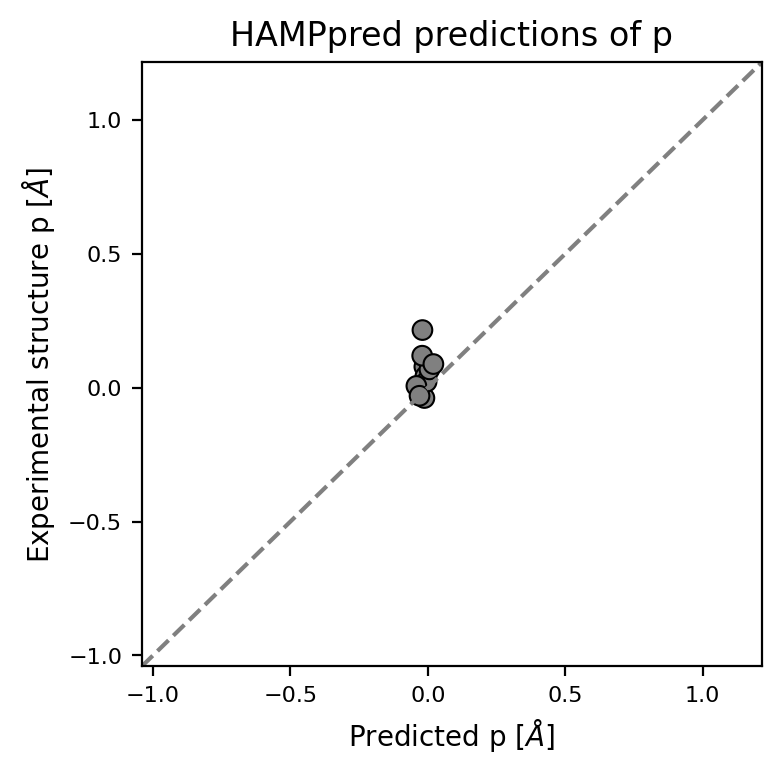

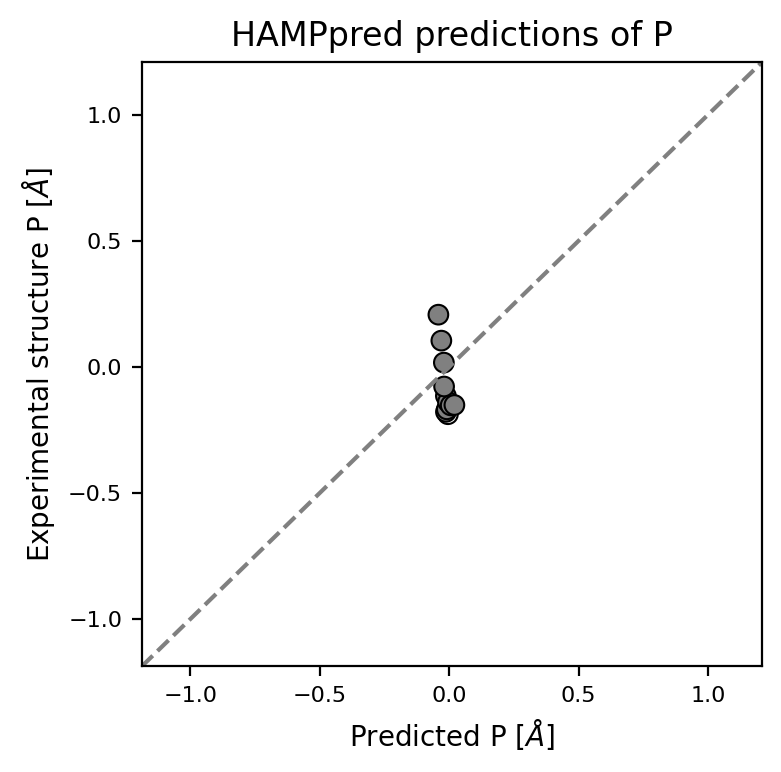

In [26]:
for param in tr:
    title_font_size = 12
    label_font_size = 10
    tick_font_size = 8
    fet = "shift"
    unit = "\AA"
    # for fet in tr_dict:
    # tr, pr = tr_dict[fet], pred_dict[fet]
    fig, ax = plt.subplots(1,1, figsize=(4, 4), dpi=200)

    colors = ['white' if i=='1_2l7i.pdb' else 'grey' for i in test_data.index]

    ax.scatter(pr[param], tr[param], color=colors, lw=0.75, edgecolors='k', s=50)
    lim_min, lim_max = min(pr[param]+tr[param]) -1, max(pr[param]+tr[param]) +1
    ax.set_ylim(lim_min, lim_max)
    ax.set_xlim(lim_min, lim_max)
    ax.plot([0, 1], [0, 1], '--', transform=ax.transAxes, color='grey')

    ax.set_xlabel(fr'Predicted {param} [${unit}$]', size=label_font_size)
    ax.set_ylabel(fr'Experimental structure {param} [${unit}$]', size=label_font_size)

    ax.tick_params(axis='both', which='major', labelsize=tick_font_size)
    ax.tick_params(axis='both', which='minor', labelsize=tick_font_size)
    ax.set_title(f"HAMPpred predictions of {param}", size=title_font_size)